<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Analyzing-Data-from-Basileus'-Generation-Setting-Experiment" data-toc-modified-id="Analyzing-Data-from-Basileus'-Generation-Setting-Experiment-1">Analyzing Data from Basileus' Generation Setting Experiment</a></span><ul class="toc-item"><li><span><a href="#Variables-in-the-dataset" data-toc-modified-id="Variables-in-the-dataset-1.1">Variables in the dataset</a></span></li><li><span><a href="#Reading-in-the-data" data-toc-modified-id="Reading-in-the-data-1.2">Reading in the data</a></span></li><li><span><a href="#Visual-data-inspection" data-toc-modified-id="Visual-data-inspection-1.3">Visual data inspection</a></span><ul class="toc-item"><li><span><a href="#Distribution-of-target-variables" data-toc-modified-id="Distribution-of-target-variables-1.3.1">Distribution of target variables</a></span></li><li><span><a href="#Relationships-between-variables" data-toc-modified-id="Relationships-between-variables-1.3.2">Relationships between variables</a></span></li></ul></li><li><span><a href="#Correlations" data-toc-modified-id="Correlations-1.4">Correlations</a></span></li><li><span><a href="#Regression-Analysis" data-toc-modified-id="Regression-Analysis-1.5">Regression Analysis</a></span><ul class="toc-item"><li><span><a href="#Randomness-predicting-Grammar/Style/Spelling" data-toc-modified-id="Randomness-predicting-Grammar/Style/Spelling-1.5.1">Randomness predicting Grammar/Style/Spelling</a></span></li><li><span><a href="#Randomness-predicting-Readability-Grade" data-toc-modified-id="Randomness-predicting-Readability-Grade-1.5.2">Randomness predicting Readability Grade</a></span><ul class="toc-item"><li><span><a href="#Regression-diagnostics-(checking-assumptions)" data-toc-modified-id="Regression-diagnostics-(checking-assumptions)-1.5.2.1">Regression diagnostics (checking assumptions)</a></span></li></ul></li><li><span><a href="#Presentation-of-Regression" data-toc-modified-id="Presentation-of-Regression-1.5.3">Presentation of Regression</a></span><ul class="toc-item"><li><span><a href="#Plotting-the-relationships" data-toc-modified-id="Plotting-the-relationships-1.5.3.1">Plotting the relationships</a></span></li></ul></li><li><span><a href="#Randomness-predicting-Glue-Index" data-toc-modified-id="Randomness-predicting-Glue-Index-1.5.4">Randomness predicting Glue Index</a></span></li></ul></li></ul></li></ul></div>

# Analyzing Data from Basileus' Generation Setting Experiment

*Put stuff here explaining on the methodology ("what was done")...*

Data can be obtained [here](https://docs.google.com/spreadsheets/d/1a-oHJdBUvwTUam7Y9U9vqEvrcd4fK2q3oqm3H4iI4G0/edit#gid=116999801)

## Variables in the dataset

Variable|Meaning|Target
-|-|-
Randomness|Generator Setting|Independent Variable
Tail-Free|Generator Setting|Independent Variable
Grammar/Style/Spelling|Your writing can have no spelling or grammar mistakes but still be awkward, clumsy, and hard to read. Style can make your writing easier and more enjoyable to read. Style covers issues like repeated sentence starts, clunky word order and phrasing, hidden verbs, and more.|Higher is better
Readability Grade|A readability score is a measure of how easy your text is to read. Your readability score shows what grade level of students could understand and engage with your writing. For instance, a score of 7 means that seventh-grade students could read your work.|Lower is better
Glue Index|Glue words are words that are common, low-quality, or nondescript, and too many of them can make your sentences "sticky". Sticky sentences slow your reader down; try to avoid them.|Lower is better

## Reading in the data

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from sklearn.preprocessing import PolynomialFeatures as polyfeat
from sklearn.linear_model import LinearRegression as linreg
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_validate, KFold
import statsmodels.formula.api as smf

# Read in data of the GSheet document
nai_rand_only = pd.read_csv(
    'https://docs.google.com/spreadsheets/d/1a-oHJdBUvwTUam7Y9U9vqEvrcd4fK2q3oqm3H4iI4G0/export?format=csv&gid=1831608934', header=1)

nai_rand_tfs = pd.read_csv(
    'https://docs.google.com/spreadsheets/d/1a-oHJdBUvwTUam7Y9U9vqEvrcd4fK2q3oqm3H4iI4G0/export?format=csv&gid=832120712', header=1)

print("First 3 lines of nai_rand_only:\n")
print(nai_rand_only.iloc[:, :15].head(3))
print(nai_rand_only.iloc[:, 15:].head(3))


print("\nFirst 3 lines of nai_rand_tfs:\n")
print(nai_rand_tfs.head(3))

First 3 lines of nai_rand_only:

   Randomness  Max Length  Min Length  Top-K  Nucleus Tail-Free  Penalty  \
0         0.6          40          20     60      0.9  disabled      2.8   
1         0.6          40          20     60      0.9  disabled      2.8   
2         0.6          40          20     60      0.9  disabled      2.8   

   Range  Slope                                                Raw  Goals  \
0    512   3.33  The colony's central courtyard was a vast expa...    NaN   
1    512   3.33  The hallways were empty save for a few people ...    NaN   
2    512   3.33  The corridor outside the dormitory was narrow,...    NaN   

   Improvements Grammar/Style/Spelling  Sentence Length  Readability Grade  
0           NaN                    74%              NaN                  5  
1           NaN                    77%              NaN                  5  
2           NaN                    65%              NaN                  6  
   Sentence Variety  Passive Voice  Complex P

In [2]:
# nai_rand_only has a few instances of the double quote bug. These have been removed for nai_rand_tfs since they tank some rating scores.
# To keep things consistent, we will remove them for nai_rand_only as well
mask = nai_rand_only["Raw"].str.contains('\S"\S', regex=True)
nai_rand_only = nai_rand_only[~mask]

In [3]:
# Combine datasets
nai = nai_rand_only.append(nai_rand_tfs)

print("\nFirst three lines of data:\n")
print(nai.iloc[:, :15].head(3))
print(nai.iloc[:, 15:].head(3))

print("\nLast three lines of data:\n")
print(nai.iloc[:, :15].tail(3))
print(nai.iloc[:, 15:].tail(3))


First three lines of data:

   Randomness  Max Length  Min Length  Top-K  Nucleus Tail-Free  Penalty  \
0         0.6        40.0        20.0   60.0      0.9  disabled      2.8   
1         0.6        40.0        20.0   60.0      0.9  disabled      2.8   
2         0.6        40.0        20.0   60.0      0.9  disabled      2.8   

   Range  Slope                                                Raw  Goals  \
0  512.0   3.33  The colony's central courtyard was a vast expa...    NaN   
1  512.0   3.33  The hallways were empty save for a few people ...    NaN   
2  512.0   3.33  The corridor outside the dormitory was narrow,...    NaN   

   Improvements Grammar/Style/Spelling  Sentence Length  Readability Grade  
0           NaN                    74%              NaN                5.0  
1           NaN                    77%              NaN                5.0  
2           NaN                    65%              NaN                6.0  
   Sentence Variety  Passive Voice  Complex Parag

In [4]:
# drop columns without data (and data without variance)
nai = nai[["Randomness", "Tail-Free", "Nucleus",
           "Grammar/Style/Spelling", "Readability Grade", "Glue Index",
          "Raw"]]

print("\nFirst three lines of data:\n")
print(nai.iloc[:, :15].head(3))
print(nai.iloc[:, 15:].head(3))

print("\nLast three lines of data:\n")
print(nai.iloc[:, :15].tail(3))
print(nai.iloc[:, 15:].tail(3))


First three lines of data:

   Randomness Tail-Free  Nucleus Grammar/Style/Spelling  Readability Grade  \
0         0.6  disabled      0.9                    74%                5.0   
1         0.6  disabled      0.9                    77%                5.0   
2         0.6  disabled      0.9                    65%                6.0   

  Glue Index                                                Raw  
0        44%  The colony's central courtyard was a vast expa...  
1        47%  The hallways were empty save for a few people ...  
2        46%  The corridor outside the dormitory was narrow,...  
Empty DataFrame
Columns: []
Index: [0, 1, 2]

Last three lines of data:

     Randomness Tail-Free  Nucleus Grammar/Style/Spelling  Readability Grade  \
366         0.9       0.9      NaN                    73%               10.0   
367         0.9       0.9      NaN                    77%                9.0   
368         0.9       0.9      NaN                    83%                8.0   



In [5]:
# Convert "disabled" for tail free to "1"
nai["Tail-Free"] = nai["Tail-Free"].replace({"disabled": "1"}).astype(float)

# Convert NaN for Nucelus to "1"
nai["Nucleus"].fillna(1, inplace = True)

# Convert % strings to float
nai[["Grammar/Style/Spelling", "Glue Index"]] = nai[["Grammar/Style/Spelling",
                                                     "Glue Index"]].astype(str).replace({"\%": ""}, regex=True).astype(float)

print("\nFirst three lines of data:\n")
print(nai.iloc[:, :15].head(3))
print(nai.iloc[:, 15:].head(3))

print("\nLast three lines of data:\n")
print(nai.iloc[:, :15].tail(3))
print(nai.iloc[:, 15:].tail(3))

nai.info()


First three lines of data:

   Randomness  Tail-Free  Nucleus  Grammar/Style/Spelling  Readability Grade  \
0         0.6        1.0      0.9                    74.0                5.0   
1         0.6        1.0      0.9                    77.0                5.0   
2         0.6        1.0      0.9                    65.0                6.0   

   Glue Index                                                Raw  
0        44.0  The colony's central courtyard was a vast expa...  
1        47.0  The hallways were empty save for a few people ...  
2        46.0  The corridor outside the dormitory was narrow,...  
Empty DataFrame
Columns: []
Index: [0, 1, 2]

Last three lines of data:

     Randomness  Tail-Free  Nucleus  Grammar/Style/Spelling  \
366         0.9        0.9      1.0                    73.0   
367         0.9        0.9      1.0                    77.0   
368         0.9        0.9      1.0                    83.0   

     Readability Grade  Glue Index  \
366               

## Visual data inspection

### Distribution of target variables

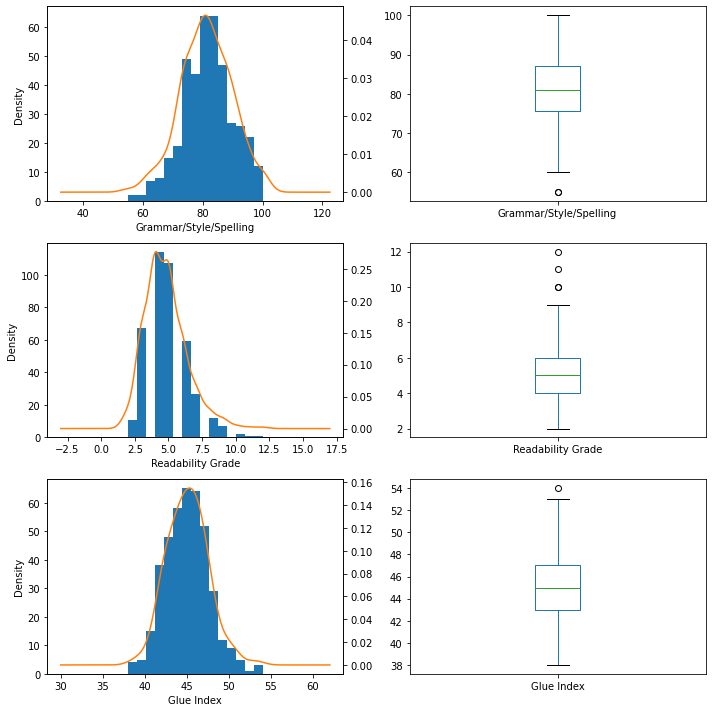

In [6]:
%matplotlib inline

fig, axes = plt.subplots(3, 2, figsize=(10, 10))

# Histograms with KDE
ax1 = nai["Grammar/Style/Spelling"].plot.hist(ax=axes[0, 0], bins=15)
ax1.set_xlabel("Grammar/Style/Spelling")
nai["Grammar/Style/Spelling"].plot.kde(ax=axes[0, 0], secondary_y=True)

ax2 = nai["Readability Grade"].plot.hist(ax=axes[1, 0], bins=15)
ax2.set_xlabel("Readability Grade")
nai["Readability Grade"].plot.kde(ax=axes[1, 0], secondary_y=True)

ax3 = nai["Glue Index"].plot.hist(ax=axes[2, 0], bins=15)
nai["Glue Index"].plot.kde(ax=axes[2, 0], secondary_y=True)
ax3.set_xlabel("Glue Index")


# Boxplots
nai["Grammar/Style/Spelling"].plot.box(ax=axes[0, 1])
nai["Readability Grade"].plot.box(ax=axes[1, 1])
nai["Glue Index"].plot.box(ax=axes[2, 1])

fig.tight_layout()
plt.show()

We have a few minor outliers, but nothing too much out of the ordinary that sticks out. I also would be hesitant to remove any outlier for analysis, since we in this case we can be sure, that all data points are truly part of the "population" (i.e. all potential outputs that we could have gotten with the respective setting).

### Relationships between variables

A few scatter plot with lowess lines to see if we are dealing with linear relationships. I'd actually expect something more like a curvilinear relationship.

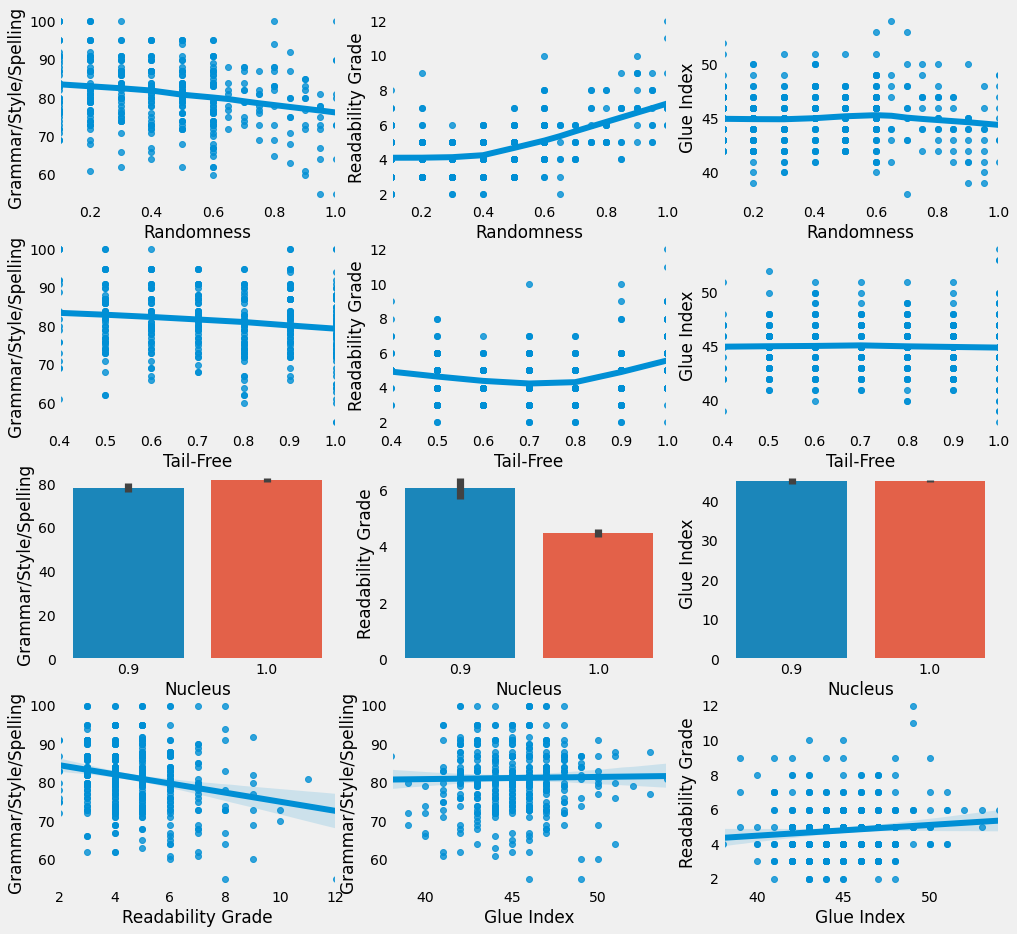

In [7]:
plt.style.use('fivethirtyeight')

fig, axes = plt.subplots(4, 3, figsize=(15, 15))
plt.grid(False)
# Relationship with Randomness
sns.regplot(data=nai, y="Grammar/Style/Spelling",
            x="Randomness", lowess=True, ax=axes[0, 0])
sns.regplot(data=nai, y="Readability Grade",
            x="Randomness", lowess=True, ax=axes[0, 1])
sns.regplot(data=nai, y="Glue Index", x="Randomness",
            lowess=True, ax=axes[0, 2])
# Relationships with TFS
sns.regplot(data=nai, y="Grammar/Style/Spelling",
            x="Tail-Free", lowess=True, ax=axes[1, 0])
sns.regplot(data=nai, y="Readability Grade",
            x="Tail-Free", lowess=True, ax=axes[1, 1])
sns.regplot(data=nai, y="Glue Index", x="Tail-Free",
            lowess=True, ax=axes[1, 2])
# Relationships with Nucleus (not much here yet since only 0.9 or 1.0)
sns.barplot(data=nai, y="Grammar/Style/Spelling",
            x="Nucleus", ax=axes[2, 0])
sns.barplot(data=nai, y="Readability Grade",
            x="Nucleus", ax=axes[2, 1])
sns.barplot(data=nai, y="Glue Index", x="Nucleus",
            ax=axes[2, 2])
# Relationships between dependent vars
sns.regplot(data=nai, y="Grammar/Style/Spelling",
            x="Readability Grade", lowess=False, ax=axes[3, 0])
sns.regplot(data=nai, y="Grammar/Style/Spelling",
            x="Glue Index", lowess=False, ax=axes[3, 1])
sns.regplot(data=nai, y="Readability Grade",
            x="Glue Index", lowess=False, ax=axes[3, 2])

for ax in fig.axes:
    ax.grid(False)

plt.show()

**(The following bit is outdated and only applies to random without tail-free. I will revise this once we have all the data)**
Hmm interesting, the relationship with Grammar/Style/Spelling looks like a weak quadratic relationship ("reverse U"), with Readability it looks a little bit cubic (but a linear relationship might be a decent enough fit with less danger of overfitting), and Glue Index might be *more or less* quadratic.

There seems to be not much reliable relationship of any kind between the target variables (will still be looking at correlations below), so a MANOVA (which depends on a linear combination of the dependent variables) is probably out of the question.

## Correlations

In [8]:
nai[["Randomness", "Tail-Free", "Nucleus", "Grammar/Style/Spelling",
     "Readability Grade", "Glue Index"]].corr()

,Randomness,Tail-Free,Nucleus,Grammar/Style/Spelling,Readability Grade,Glue Index
Randomness,1.000000,0.488916,-0.693600,-0.253901,0.538097,-0.003166
Tail-Free,0.488916,1.000000,-0.640747,-0.170379,0.215806,-0.005966
Nucleus,-0.693600,-0.640747,1.000000,0.166514,-0.405536,-0.007027
Grammar/Style/Spelling,-0.253901,-0.170379,0.166514,1.000000,-0.218084,0.016515
Readability Grade,0.538097,0.215806,-0.405536,-0.218084,1.000000,0.098913
Glue Index,-0.003166,-0.005966,-0.007027,0.016515,0.098913,1.000000


**(The following bit is outdated and only applies to random without tail-free. I will revise this once we have all the data)**
Best to ignore the results for correlations Randomness <-> Grammar/Style/Spelling and Randomness <-> Glue Index, since the relationship clearly is non-linear.

Otherwise:
* Strong negative linear relations between Readability and Randomness (lower is better for readability) so: the higher the randomness, the worse readability tends to be)
* The 3 target variables really have weak to none linear relationships with each other

## Regression Analysis

In [9]:
# Drop rows without values for the dependent vars, can be deleted later if all the data is in
nai.dropna(subset=["Grammar/Style/Spelling",
                   "Readability Grade", "Glue Index"], inplace=True)

In [10]:
# Setting up k-fold cross validation

kf = KFold(10, shuffle=True, random_state=42)

# Defining predictors for models
nai["Rand_cent"] = nai["Randomness"].apply(
    lambda x: x-nai["Randomness"].mean())  # centering
nai["TFS_cent"] = nai["Tail-Free"].apply(lambda x: x-nai["Tail-Free"].mean())
nai["Nuc_cent"] = nai["Nucleus"].apply(lambda x: x-nai["Nucleus"].mean())
predictors = nai[["Rand_cent", "TFS_cent", "Nuc_cent"]]

# to include interaction
poly_lin = polyfeat(interaction_only=True, include_bias=False)
lin_predictors = poly_lin.fit_transform(predictors)
poly_quad = polyfeat(degree=2, include_bias=False)
quad_predictors = poly_quad.fit_transform(predictors)
poly_cub = polyfeat(degree=3, include_bias=False)
cub_predictors = poly_cub.fit_transform(predictors)
# poly_quart = polyfeat(degree=4, include_bias=False)
# quart_predictors = poly_quart.fit_transform(predictors)
# poly_quint = polyfeat(degree=5, include_bias=False)
# quint_predictors = poly_quint.fit_transform(predictors)

# Display created feature names
print("Linear features:")
print(poly_lin.get_feature_names(predictors.columns))
print("\nQuadratic features:")
print(poly_quad.get_feature_names(predictors.columns))
print("\nCubic features:")
print(poly_cub.get_feature_names(predictors.columns))
# print("\nQuartic features:")
# print(poly_quart.get_feature_names(predictors.columns))
# print("\nQuintic features:")
# print(poly_quint.get_feature_names(predictors.columns))

Linear features:
['Rand_cent', 'TFS_cent', 'Nuc_cent', 'Rand_cent TFS_cent', 'Rand_cent Nuc_cent', 'TFS_cent Nuc_cent']

Quadratic features:
['Rand_cent', 'TFS_cent', 'Nuc_cent', 'Rand_cent^2', 'Rand_cent TFS_cent', 'Rand_cent Nuc_cent', 'TFS_cent^2', 'TFS_cent Nuc_cent', 'Nuc_cent^2']

Cubic features:
['Rand_cent', 'TFS_cent', 'Nuc_cent', 'Rand_cent^2', 'Rand_cent TFS_cent', 'Rand_cent Nuc_cent', 'TFS_cent^2', 'TFS_cent Nuc_cent', 'Nuc_cent^2', 'Rand_cent^3', 'Rand_cent^2 TFS_cent', 'Rand_cent^2 Nuc_cent', 'Rand_cent TFS_cent^2', 'Rand_cent TFS_cent Nuc_cent', 'Rand_cent Nuc_cent^2', 'TFS_cent^3', 'TFS_cent^2 Nuc_cent', 'TFS_cent Nuc_cent^2', 'Nuc_cent^3']


In [11]:
# We do not need interactions between TFS x Nucleus, so we are removing those
# Also removing poly terms for Nucleus (should be kept once we have more data for Nucleus)
lin_predictors = np.delete(lin_predictors, 5, axis = 1)
quad_predictors = np.delete(quad_predictors, np.s_[7:], axis = 1)
# Quite a lot of features to remove for cubic - working from the back of the array...
cub_predictors = np.delete(cub_predictors, np.s_[16:], axis = 1) # remove TFS x Nucleus poly ints and Nucleus**3
cub_predictors = np.delete(cub_predictors, np.s_[13, 14], axis = 1) # remove Rand x TFS x Nucleus and Rand x Nucleus**2
cub_predictors = np.delete(cub_predictors, np.s_[7:9], axis = 1) # remove TFS x Nucleus and Nucleus ** 2

In [12]:
# setup scikit linear model
lin_model = linreg()

# setup list of model names with predictor arrays
predictor_li = [("linear", lin_predictors), ("quadratic", quad_predictors),
                ("cubic", cub_predictors)]
# predictor_li = [("linear", lin_predictors), ("quadratic", quad_predictors),
#                 ("cubic", cub_predictors), ("quartic", quart_predictors), ("quintic", quint_predictors)]

### Randomness predicting Grammar/Style/Spelling

In [13]:
# Select best model
for pred in predictor_li:
    current_pred = pred[1]
    current_model_name = pred[0]
    cross_val = cross_validate(lin_model, current_pred, nai["Grammar/Style/Spelling"],
                               scoring=["neg_mean_squared_error", "r2"], cv=kf)
    neg_mses = cross_val["test_neg_mean_squared_error"]
    r_squares = cross_val["test_r2"]
    avg_rmse = np.mean((neg_mses*-1)**0.5)
    avg_r_sq = np.mean(r_squares)
    print("Model performance for {} model predicting Grammar/Style/Spelling:".format(current_model_name))
    print("r-square: {:.4f}    RMSE: {:.2f}\n".format(avg_r_sq, avg_rmse))

Model performance for linear model predicting Grammar/Style/Spelling:
r-square: -0.0003    RMSE: 8.31

Model performance for quadratic model predicting Grammar/Style/Spelling:
r-square: -0.0100    RMSE: 8.35

Model performance for cubic model predicting Grammar/Style/Spelling:
r-square: -0.0199    RMSE: 8.38



These model performances are all so terrible, that I would not bother to investigate further - there might be a *very small* relationship here (our sample is quite big), but it is too small to really matter in practice

### Randomness predicting Readability Grade

In [14]:
# Select best model
for pred in predictor_li:
    current_pred = pred[1]
    current_model_name = pred[0]
    cross_val = cross_validate(lin_model, current_pred, nai["Readability Grade"],
                               scoring=["neg_mean_squared_error", "r2"], cv=kf)
    neg_mses = cross_val["test_neg_mean_squared_error"]
    r_squares = cross_val["test_r2"]
    avg_rmse = np.mean((neg_mses*-1)**0.5)
    avg_r_sq = np.mean(r_squares)
    print("Model performance for {} model predicting Readability:".format(
        current_model_name))
    print("r-square: {:.4f}    RMSE: {:.2f}\n".format(avg_r_sq, avg_rmse))

Model performance for linear model predicting Readability:
r-square: 0.2717    RMSE: 1.26

Model performance for quadratic model predicting Readability:
r-square: 0.3254    RMSE: 1.20

Model performance for cubic model predicting Readability:
r-square: 0.3126    RMSE: 1.21



This looks more promising, continuing with quadratic model.

#### Regression diagnostics (checking assumptions)

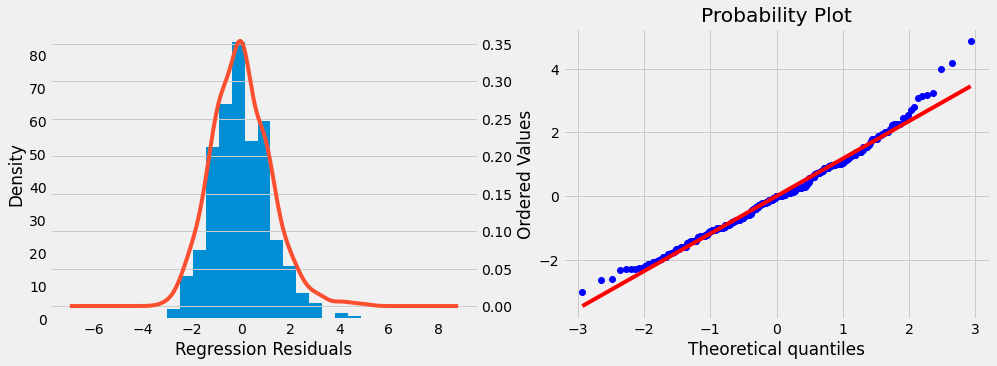

In [15]:
# Fit model and save residuals
lin_model.fit(quad_predictors, nai["Readability Grade"])

pred = lin_model.predict(quad_predictors)
obs_pred_res_df = pd.DataFrame(
    {'Actual': nai["Readability Grade"], 'Predicted': pred})
obs_pred_res_df["Residuals"] = obs_pred_res_df['Actual'] - \
    obs_pred_res_df['Predicted']

# Check for normal distribution of residuals with histogram and Q-Q plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histograms with KDE
ax1 = obs_pred_res_df["Residuals"].plot.hist(ax=axes[0], bins=15)
ax1.set_xlabel("Regression Residuals")
obs_pred_res_df["Residuals"].plot.kde(ax=axes[0], secondary_y=True)
# Q-Q Plot
stats.probplot(obs_pred_res_df["Residuals"], dist="norm", plot=axes[1])
plt.show()

Residuals are (approximately) normally distributed.

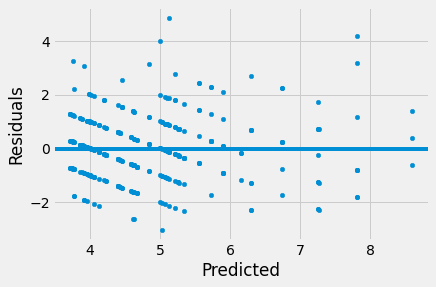

In [16]:
# Checking for Homoscedasticity

plot = obs_pred_res_df.plot.scatter(x="Predicted", y="Residuals")
#horiz_line_data = np.array([40 for i in xrange(len(xs))])
plt.axhline(y=0, linestyle='-')
plt.show()

Residuals seem close enough to homoscedacity - looks like assumptions for a linear regression hold!

### Presentation of Regression

In [17]:
import statsmodels.api as sm

model = smf.ols(
    data=nai, formula="Q('Readability Grade') ~ Rand_cent + I(Rand_cent**2) + \
    TFS_cent + I(TFS_cent**2) + \
    Nuc_cent + \
    Rand_cent:TFS_cent + Rand_cent:Nuc_cent")

# the names for the predictors are getting tedious to read, so setting up custom names
x_names = ["Intercept",
           "Randomness", "Randomness**2",
           "TF-Sampling", "TF-Sampling**2",
           "Nucleus Sampling",
           "Randomness x TF-Sampling", "Randomness x Nucleus Sampling"]

res = model.fit()
print("Cubic Model Predicting Readability with CENTERED (!) Predcitors\n")
# print(res.summary())
print(res.summary(xname=x_names))

Cubic Model Predicting Readability with CENTERED (!) Predcitors

                              OLS Regression Results                              
Dep. Variable:     Q('Readability Grade')   R-squared:                       0.424
Model:                                OLS   Adj. R-squared:                  0.414
Method:                     Least Squares   F-statistic:                     42.01
Date:                    Tue, 29 Jun 2021   Prob (F-statistic):           2.81e-44
Time:                            14:39:24   Log-Likelihood:                -646.70
No. Observations:                     408   AIC:                             1309.
Df Residuals:                         400   BIC:                             1341.
Df Model:                               7                                         
Covariance Type:                nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------

**THIS IS ALSO OUTDATED WILL BE UPDATED LATER**

The randomness settings explains a whooping 30% of the variation of the Readability Grade. 

Remember, that the readability represents "what grade level of students could understand and engage with your writing. For instance, a score of 7 means that seventh-grade students could read your work.". 

A *lower* readability score is thus better (although arguably if it gets *too* low, the style might become a bit "primitive"? The formula for the expected readability *with everything on default setting* is:

Readability Grade = 0.34 + (7.1 * Randomness Setting)

#### Plotting the relationships
For now, I will be plotting a line with predicted values for TFS = 1 (no sampling), 0.9, 0.8, 0.7, 0.6, 0.5) and randomness values with 0.05 steps (but it should stay in the range we have data for)

In [18]:
tfs_plot_values = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
rand_plot_values = np.arange(0.1, 1.0, 0.05)
nucleus_plot_values = [1, 0.9] # not used for now

# Construct dataframe with values to predict (all in one graph)
pred_df = pd.DataFrame()

for tfs_val in tfs_plot_values:
    # The regression used centered values so we need to transform tfs_val as well
    tfs_val_cent = tfs_val - nai["Tail-Free"].mean()
    # When tfs is off (1), graph for nucleus sampling = 0.9
    if tfs_val == 1:
        nucleus_val = 0.9
    else:
        nucleus_val = 1
    nuc_val_cent = 0.9 - nai["Nucleus"].mean()

    # determine range of data for current Nucleus
    mask = (nai["Nucleus"] == nucleus_val) & (nai["Tail-Free"] == tfs_val)
    rand_min = nai[mask]["Randomness"].min()
    rand_max = nai[mask]["Randomness"].max()

    current_rand_range = np.arange(rand_min, rand_max+0.05, 0.05)
    current_rand_range_cent = current_rand_range - nai["Randomness"].mean()

    current_pred_df = pd.DataFrame(
        {"const": 1, "Randomness": current_rand_range, "Tail-Free Sampling": tfs_val, "Nucleus": nucleus_val,
         "Rand_cent": current_rand_range_cent, "TFS_cent":tfs_val_cent, "Nuc_cent": nuc_val_cent})
    pred_df = pred_df.append(current_pred_df, ignore_index = True)

# Add predicted readability to table constructed above
pred_df["Predicted Readbility"] = res.predict(pred_df[["const", "Rand_cent", "TFS_cent", "Nuc_cent"]])

# replace Tail-Free Sampling 1 with "No TFS (NS = 0.9)"
pred_df["Tail-Free Sampling"].replace(1, "No TFS (NS = 0.9)", inplace = True)

print(pred_df[["Randomness", "Tail-Free Sampling", "Nucleus", "Predicted Readbility"]].head(10))

# Dataframe for displaying main effect of TFS only
tfs_only_plot_values = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4]

pred_tfs_only_df = pd.DataFrame()

for tfs_val in tfs_only_plot_values:
    # The regression used centered values so we need to transform tfs_val as well
    tfs_val_cent = tfs_val - nai["Tail-Free"].mean()
    # Only plotting for tfs so nucleus is off (=1)
    nuc_val_cent = 1 - nai["Nucleus"].mean()
    # Plot for average randomness
    rand_val_cent = 0
    
    current_pred_dict = (
        {"const": 1, "Tail-Free Sampling": tfs_val,
         "Rand_cent": rand_val_cent, "TFS_cent":tfs_val_cent, "Nuc_cent": nuc_val_cent})
    pred_tfs_only_df = pred_tfs_only_df.append(current_pred_dict, ignore_index = True)

# Add predicted readability to table constructed above
pred_tfs_only_df["Predicted Readbility"] = res.predict(pred_tfs_only_df[["const", "Rand_cent", "TFS_cent", "Nuc_cent"]])

print(pred_tfs_only_df[["Tail-Free Sampling", "Predicted Readbility"]].head(10))


   Randomness Tail-Free Sampling  Nucleus  Predicted Readbility
0        0.60  No TFS (NS = 0.9)      0.9              4.841041
1        0.65  No TFS (NS = 0.9)      0.9              5.022963
2        0.70  No TFS (NS = 0.9)      0.9              5.259208
3        0.75  No TFS (NS = 0.9)      0.9              5.549775
4        0.80  No TFS (NS = 0.9)      0.9              5.894664
5        0.85  No TFS (NS = 0.9)      0.9              6.293877
6        0.90  No TFS (NS = 0.9)      0.9              6.747412
7        0.95  No TFS (NS = 0.9)      0.9              7.255269
8        1.00  No TFS (NS = 0.9)      0.9              7.817449
9        0.10                0.9      1.0              5.685529
   Tail-Free Sampling  Predicted Readbility
0                 0.9              4.276581
1                 0.8              4.121948
2                 0.7              4.152348
3                 0.6              4.367783
4                 0.5              4.768252
5                 0.4           

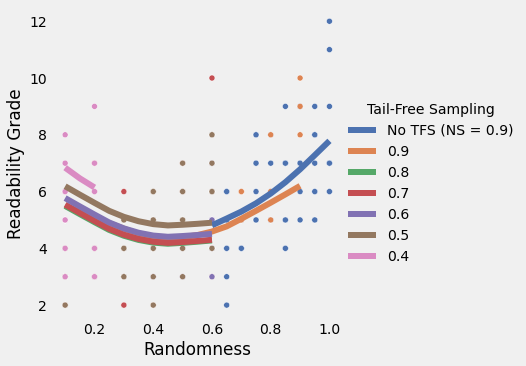

In [19]:
hue_order_lm = ["No TFS (NS = 0.9)", 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]
hue_order_scatter = [1, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4]

read_tfs_rand = sns.lmplot(data=pred_df, y="Predicted Readbility",
           x="Randomness", hue="Tail-Free Sampling", lowess=True, scatter=False, palette="deep", hue_order=hue_order_lm, legend_out=True)
read_tfs_rand = sns.scatterplot(data=nai, y="Readability Grade", x="Randomness", hue="Tail-Free",
                 palette="deep", legend=False, hue_order=hue_order_scatter)
plt.grid(False)
plt.xlim(0.05,1.05)
plt.ylabel("Readability Grade")
plt.show()

read_tfs_rand.figure.savefig('Readability_TFS_Randomness.png', bbox_inches = "tight")

# No longer used...
# fig = sm.graphics.plot_partregress_grid(res, exog_idx=[1, 2])
# fig.set_size_inches(10, 5)
# fig.tight_layout(pad=1.0)

# x_labels = ["Randomness", "Tail-Free"]

# for ax, x_label in zip(fig.get_axes(), x_labels):
#     ax.set_ylabel("Readability")
#     ax.set_xlabel(x_label)

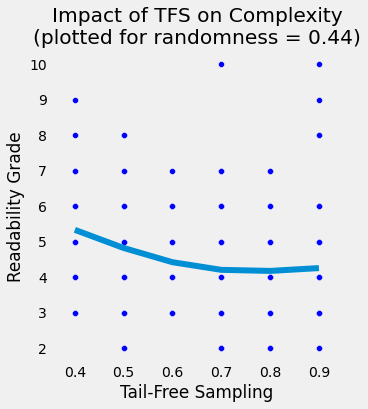

AttributeError: 'AxesSubplot' object has no attribute 'savefig'

In [20]:
avg_rand = nai["Randomness"].mean()
title = "Impact of TFS on Complexity\n(plotted for randomness = {:.2f})".format(avg_rand)

figure = sns.lmplot(data=pred_tfs_only_df, y="Predicted Readbility",
           x="Tail-Free Sampling", lowess=True, scatter=False)

mask = nai["Tail-Free"] < 1
figure = sns.scatterplot(data=nai[mask], y="Readability Grade", x="Tail-Free", color = "blue")
plt.grid(False)
plt.ylabel("Readability Grade")
plt.xlim(0.35,0.95)
plt.title(title)
plt.show()

figure.savefig('Readability_TFS.png')

### Randomness predicting Glue Index

In [ ]:
# Select best model
for pred in predictor_li:
    current_pred = pred[1]
    current_model_name = pred[0]
    cross_val = cross_validate(lin_model, current_pred, nai["Glue Index"],
                               scoring=["neg_mean_squared_error", "r2"], cv=kf)
    neg_mses = cross_val["test_neg_mean_squared_error"]
    r_squares = cross_val["test_r2"]
    avg_rmse = np.mean((neg_mses*-1)**0.5)
    avg_r_sq = np.mean(r_squares)
    print("Model performance for {} model predicting Glue Index:".format(
        current_model_name))
    print("r-square: {:.4f}    RMSE: {:.2f}\n".format(avg_r_sq, avg_rmse))

More abysmal model performance - will not bother to investigate further... 

In [ ]:
# save the data for people who want to use R Studio or similar

nai.to_csv("NAI_generation_setting_exp.csv")